In [3]:
!python3 -m pip install pyyaml==5.1
import sys, os, distutils.core
# # Note: This is a faster way to install detectron2 in Colab, but it does not include all functionalities (e.g. compiled operators).
# # See https://detectron2.readthedocs.io/tutorials/install.html for full installation instructions
!git clone 'https://github.com/facebookresearch/detectron2'
dist = distutils.core.run_setup("./detectron2/setup.py")
!python3 -m pip install {' '.join([f"'{x}'" for x in dist.install_requires])}
sys.path.insert(0, os.path.abspath('./detectron2'))

Defaulting to user installation because normal site-packages is not writeable
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 274.2/274.2 KB 3.1 MB/s eta 0:00:00a 0:00:01
  Preparing metadata (setup.py) ... error
  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> [48 lines of output]
      /home/thanush/.local/lib/python3.10/site-packages/setuptools/config/setupcfg.py:293: _DeprecatedConfig: Deprecated config in `setup.cfg`
      !!
      
              ********************************************************************************
              The license_file parameter is deprecated, use license_files instead.
      
              This deprecation is overdue, please update your project and remove deprecated
              calls to avoid build errors in the future.
      
              See https://setuptools.pypa.io/en/latest/userguide/declarative_config.html for details.
              **********************************

In [4]:
import torch, detectron2
!nvcc --version
TORCH_VERSION = ".".join(torch.__version__.split(".")[:2])
CUDA_VERSION = torch.__version__.split("+")[-1]
print("torch: ", TORCH_VERSION, "; cuda: ", CUDA_VERSION)
print("detectron2:", detectron2.__version__)

/bin/bash: line 1: nvcc: command not found
torch:  2.1 ; cuda:  cu118
detectron2: 0.6


In [5]:
# Some basic setup:
# Setup detectron2 logger
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
import os, json, cv2, random

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog

matplotlib data path: /usr/share/matplotlib/mpl-data
CONFIGDIR=/home/thanush/.config/matplotlib
interactive is False
platform is linux
loaded modules: ['sys', 'builtins', '_frozen_importlib', '_imp', '_thread', '_warnings', '_weakref', '_io', 'marshal', 'posix', '_frozen_importlib_external', 'time', 'zipimport', '_codecs', 'codecs', 'encodings.aliases', 'encodings', 'encodings.utf_8', '_signal', '_abc', 'abc', 'io', '__main__', '_stat', 'stat', '_collections_abc', 'genericpath', 'posixpath', 'os.path', 'os', '_sitebuiltins', '_distutils_hack', 'types', 'importlib._bootstrap', 'importlib._bootstrap_external', 'warnings', 'importlib', 'importlib._abc', 'itertools', 'keyword', '_operator', 'operator', 'reprlib', '_collections', 'collections', '_functools', 'functools', 'contextlib', 'importlib.util', 'importlib.machinery', 'mpl_toolkits', 'apport_python_hook', 'sitecustomize', 'site', 'runpy', 'enum', '_sre', 'sre_constants', 'sre_parse', 'sre_compile', '_locale', 'copyreg', 're', 'collec

In [5]:
from detectron2.data.datasets import register_coco_instances
register_coco_instances("part_train2", {}, "/kaggle/input/parts-mowito2/Coco-segmented/train/_annotations.coco.json", "/kaggle/input/parts-mowito2/Coco-segmented/train")
# register_coco_instances("fuel_cap_valid", {}, "/kaggle/working/valid/_annotations.coco.json", "/kaggle/working/valid")
register_coco_instances("part_test2", {}, "/kaggle/input/parts-mowito2/Coco-segmented/test/_annotations.coco.json", "/kaggle/input/parts-mowito2/Coco-segmented/test")

In [6]:
from detectron2.engine import DefaultTrainer

cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = ("part_train2",)
cfg.DATASETS.TEST = ()
cfg.DATALOADER.NUM_WORKERS = 2
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")  # Let training initialize from model zoo
cfg.SOLVER.IMS_PER_BATCH = 2  # This is the real "batch size" commonly known to deep learning people
cfg.SOLVER.BASE_LR = 0.00025  # pick a good LR
cfg.SOLVER.MAX_ITER = 500    # 300 iterations seems good enough for this toy dataset; you will need to train longer for a practical dataset
cfg.SOLVER.STEPS = []        # do not decay learning rate
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 512   # The "RoIHead batch size". 128 is faster, and good enough for this toy dataset (default: 512)
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 1 # only has one class (ballon). (see https://detectron2.readthedocs.io/tutorials/datasets.html#update-the-config-for-new-datasets)
# NOTE: this config means the number of classes, but a few popular unofficial tutorials incorrect uses num_classes+1 here.

# os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
# trainer = DefaultTrainer(cfg)
# trainer.resume_or_load(resume=False)
# trainer.train()

In [7]:
cfg.MODEL.WEIGHTS = "./model_final.pth"  # path to the model we just trained
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5   # set a custom testing threshold
predictor = DefaultPredictor(cfg)

[05/15 13:30:05 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from ./model_final.pth ...
[Checkpointer] Loading from ./model_final.pth ...


In [9]:
from detectron2.utils.visualizer import ColorMode
im = cv2.imread("/media/thanush/Misc1/Mowito/Test_images/dist.jpg")
outputs = predictor(im)
outputs  # format is documented at https://detectron2.readthedocs.io/tutorials/models.html#model-output-format

/media/thanush/Misc1/Mowito/Object_detection_model_weights/detectron2/detectron2/layers/wrappers.py:142: UserWarning: Applied workaround for CuDNN issue, install nvrtc.so (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:80.)
  x = F.conv2d(
/home/thanush/.local/lib/python3.10/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3526.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


{'instances': Instances(num_instances=1, image_height=500, image_width=889, fields=[pred_boxes: Boxes(tensor([[252.1124, 166.9612, 606.2842, 491.0216]], device='cuda:0')), scores: tensor([0.9852], device='cuda:0'), pred_classes: tensor([0], device='cuda:0'), pred_masks: tensor([[[False, False, False,  ..., False, False, False],
          [False, False, False,  ..., False, False, False],
          [False, False, False,  ..., False, False, False],
          ...,
          [False, False, False,  ..., False, False, False],
          [False, False, False,  ..., False, False, False],
          [False, False, False,  ..., False, False, False]]], device='cuda:0')])}

In [10]:
import matplotlib.pyplot as plt
import cv2
import glob

images = [cv2.imread(file) for file in glob.glob('/media/thanush/Misc1/Mowito/Coco-segmented/valid/*.jpg')]

import os

mylist = os.listdir("/media/thanush/Misc1/Mowito/Coco-segmented/valid/")
mylist

Loaded backend module://matplotlib_inline.backend_inline version unknown.
Loaded backend module://matplotlib_inline.backend_inline version unknown.


['screenshot_2024-05-02_17-11-22_jpg.rf.79b19165c36d638be43f1e845033858f.jpg',
 'screenshot_2024-05-02_17-19-10_jpg.rf.82453660c0aaa236e74bb8a5e9450a90.jpg',
 'screenshot_2024-05-02_17-23-31_jpg.rf.89d33857981f689241cf83e52012e0ff.jpg',
 '_annotations.coco.json']

In [11]:
from detectron2.utils.visualizer import ColorMode
imval = []
for d in range(0,3):    
    im = cv2.imread("/media/thanush/Misc1/Mowito/Coco-segmented/valid/"+mylist[d])
    outputs = predictor(im)  # format is documented at https://detectron2.readthedocs.io/tutorials/models.html#model-output-format
    v = Visualizer(im[:, :, ::-1],
                   scale=0.5, 
                   instance_mode=ColorMode.IMAGE  # remove the colors of unsegmented pixels. This option is only available for segmentation models
    )
    out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    imval.append(out.get_image()[:, :, ::-1])
#     plt.imshow(cv2.cvtColor(out.get_image()[:, :, ::-1],cv2.COLOR_BGR2RGB))

findfont: Matching sans\-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=10.0.
findfont: score(FontEntry(fname='/usr/share/matplotlib/mpl-data/fonts/ttf/DejaVuSans-BoldOblique.ttf', name='DejaVu Sans', style='oblique', variant='normal', weight=700, stretch='normal', size='scalable')) = 1.335
findfont: score(FontEntry(fname='/usr/share/matplotlib/mpl-data/fonts/ttf/DejaVuSerif-Italic.ttf', name='DejaVu Serif', style='italic', variant='normal', weight=400, stretch='normal', size='scalable')) = 11.05
findfont: score(FontEntry(fname='/usr/share/matplotlib/mpl-data/fonts/ttf/DejaVuSerif-Bold.ttf', name='DejaVu Serif', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 10.335
findfont: score(FontEntry(fname='/usr/share/matplotlib/mpl-data/fonts/ttf/cmex10.ttf', name='cmex10', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
findfont: score(FontEntry(fname='/usr/share/matplotlib/mpl-data/fonts/ttf/ST

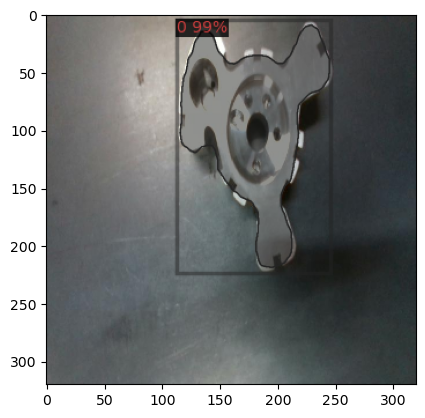

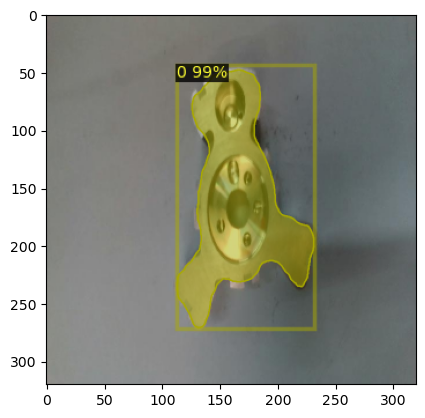

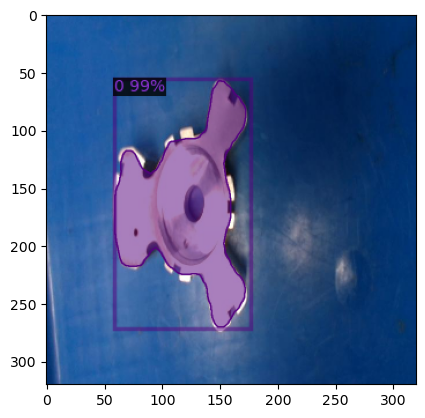

In [13]:
for im in range(0,3):
    plt.imshow( cv2.cvtColor(imval[im], cv2.COLOR_BGR2RGB))
    plt.show()

In [12]:
import torch
import torchvision
from detectron2.export.flatten import TracingAdapter
from detectron2.modeling import build_model

def inference_func(model, image):
    inputs = [{"image": image}]
    return model.inference(inputs, do_postprocess=False)[0]

print("cfg.MODEL.WEIGHTS: ",cfg.MODEL.WEIGHTS)   ## RETURNS : cfg.MODEL.WEIGHTS:  drive/Detectron2/model_final.pth
model = build_model(cfg)
example = torch.rand(3, 224, 224)
wrapper = TracingAdapter(model, example, inference_func)
wrapper.eval()
traced_script_module = torch.jit.trace(wrapper, (example,))
traced_script_module.save("./model-final.pt")

cfg.MODEL.WEIGHTS:  ./output/model_final.pth


/kaggle/working/detectron2/detectron2/structures/image_list.py:85: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  assert t.shape[:-2] == tensors[0].shape[:-2], t.shape
/kaggle/working/detectron2/detectron2/structures/boxes.py:151: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  if tensor.numel() == 0:
/kaggle/working/detectron2/detectron2/structures/boxes.py:155: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the fu

In [13]:
%cd /kaggle/working

/kaggle/working


In [14]:
from IPython.display import FileLink -> FileLink(r'model-final.pt')

SyntaxError: invalid syntax (1697060922.py, line 1)